## Student Number : 408846
## Student Name : Ibrahim Sahin

# Image based en Grid based classificatie

In de voorgaande notebooks hebben we gekeken naar de mogelijkheden van image based en grid based classificatie. In deze notebook zullen we de features gebruiken van beide notebooks om te kijken of dit betere resultaten oplevert.

## Uitvoering

Om dit probleem op te pakken zullen we de workflow hanteren die voornamelijk worden gebruikt binnen een Machine learning probleem (Data Science lifecycle). De workflow is te verdelen in de volgende stappen:

1. Data verzamelen
2. Data analyseren
3. Preprocessen
4. Feature engineering
5. Trainen / Testen / Evalueren

Allereerst beginnen we met het importeren van de libraries die we nodig zullen hebben in onze code.

In [47]:
import cv2
import os
import numpy as np
import skimage

from skimage import io, transform, color, filters, data, morphology, measure

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [48]:
def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename[0:4])
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})

    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

all_images_df = load_images_from_folder('../dataset-images/all_images')
all_images_df
train_images_df = all_images_df.sample(frac=0.9, random_state=25)

test_images_df = all_images_df.drop(train_images_df.index)

train_images_df.reset_index(inplace=True,drop=True)
test_images_df.reset_index(inplace=True,drop=True)


De hierboven gedefineerde functies zijn geleverd door Saxion zelf. Die zullen gebruikt worden voor het inladen van de data en het tonen van de afbeeldingen.

In [49]:
def initialize_image_grids(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    binary_splitted = [binary[:, :32], binary[:, 32:64], binary[:, 64:96], binary[:, 96:128]]
    
    df = pd.DataFrame()
    lol = len(binary_splitted)
    if (lol < 4):
        print('splitted is smaller than 4')
    for x in range(0, len(binary_splitted)):
        
        test = binary_splitted[x]
        height = 8
        width = 8

        s_width = 0
        s_heigth = 0

        df.loc[x, 'zip_number'] = image_name[x]

        for i in range(1, 17):
            h = s_heigth+height
            w = s_width+width
            feat = test[s_heigth:h, s_width:w]
            white_pixels = feat[feat==1]
            total_white_pixels = len(white_pixels)
            df.loc[x, i] = total_white_pixels
            if (i%4 == 0):
                s_width = 0
                s_heigth = s_heigth + height
            else:
                s_width = s_width + width
        
    return df

image_properties = ['label', 'area', 'centroid', 
                    'perimeter', 'eccentricity', 'euler_number',
                    'filled_area','perimeter_crofton', 'local_centroid', 
                    'major_axis_length', 'minor_axis_length', 'orientation']

def initialize_image_props(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    
    # remove the white small spots/dots
    binary = morphology.binary_opening(binary)
    
    # make the white zip numbers thicker
    binary = morphology.binary_dilation(binary)
    
    # some numbers may have holes in it. That could seperate the number in 2 different labels. with closing the gap will be closed
    binary = morphology.binary_closing(binary)
    
    # return number back to its original state before it was made thicker. make the numbers thinner
    binary = morphology.binary_erosion(binary)
    
    label_image, total_labels = measure.label(binary, return_num=True)

    global image_properties
    props = measure.regionprops_table(label_image, properties=image_properties)
    tmp_df = pd.DataFrame(props)
    
    # filter out labels that have too small areas. these labels are small dots that could not be filled with the opening function
    tmp_df = tmp_df.query('area > 50').reset_index(drop=True)

    zip_numbers = list(image_name)[:4]
        
    return tmp_df


In [62]:
result = pd.DataFrame()

for i in range(0, len(train_images_df.index)):
    image_name = train_images_df.iloc[i,0]
    image = train_images_df.iloc[i,1]
    tmp_result_grid = initialize_image_grids(image, image_name)
    tmp_result_props = initialize_image_props(image, image_name)
    tmp_result = pd.concat([tmp_result_grid,tmp_result_props], axis=1)
    result = pd.concat([result, tmp_result])


result.reset_index(inplace=True, drop=True)
result.drop(columns=['label'], inplace=True)
result["zip_number"] = pd.to_numeric(result["zip_number"])
result  

,zip_number,1,2,3,4,5,6,7,8,9,...,perimeter,eccentricity,euler_number,filled_area,perimeter_crofton,local_centroid-0,local_centroid-1,major_axis_length,minor_axis_length,orientation
0,1,0.0,3.0,47.0,0.0,6.0,42.0,52.0,0.0,4.0,...,89.840620,0.879793,1,272,87.855766,15.238971,10.816176,32.379127,15.391637,0.044635
1,4,0.0,19.0,22.0,0.0,1.0,39.0,11.0,21.0,25.0,...,124.124892,0.676449,1,311,120.359293,17.598071,11.803859,30.923689,22.774959,-0.284669
2,9,0.0,42.0,41.0,1.0,1.0,46.0,49.0,12.0,5.0,...,141.438600,0.818740,0,388,134.092201,15.252149,11.183381,36.800284,21.129437,-0.044963
3,5,3.0,58.0,46.0,2.0,12.0,52.0,12.0,0.0,1.0,...,113.053824,0.904714,1,329,109.863263,13.984802,7.772036,37.710584,16.065428,-0.005646
4,4,9.0,10.0,52.0,6.0,13.0,33.0,51.0,8.0,23.0,...,98.811183,0.795305,1,352,96.360393,16.701705,12.798295,30.494542,18.486091,-0.018643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,7,2.0,53.0,55.0,7.0,4.0,37.0,61.0,23.0,1.0,...,91.740115,0.836679,1,382,89.656600,12.654450,8.657068,32.454314,17.775027,-0.138335
1724,6,8.0,38.0,18.0,2.0,8.0,44.0,4.0,6.0,8.0,...,127.438600,0.826591,0,363,120.819369,18.587692,8.375385,34.897599,19.640498,0.304641
1725,1,7.0,2.0,54.0,2.0,10.0,36.0,60.0,6.0,8.0,...,91.740115,0.870053,1,285,89.656600,15.161404,11.564912,32.025504,15.787250,0.006075
1726,7,10.0,44.0,58.0,5.0,4.0,30.0,58.0,14.0,4.0,...,109.982756,0.874299,1,337,106.951708,13.219585,8.498516,35.514176,17.238121,-0.188826


In [63]:
result.describe(include='all')

,zip_number,1,2,3,4,5,6,7,8,9,...,perimeter,eccentricity,euler_number,filled_area,perimeter_crofton,local_centroid-0,local_centroid-1,major_axis_length,minor_axis_length,orientation
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,4.506366,5.077546,40.752315,37.320023,6.612847,7.591435,36.108796,34.551505,7.057870,6.132523,...,117.812376,0.855734,0.641204,355.395833,113.627233,15.441678,9.626942,36.412613,18.282600,0.053658
std,2.870081,4.714772,12.402672,14.015213,8.223288,6.085073,14.940328,16.311733,7.133933,6.114837,...,16.962037,0.055155,0.558944,62.740932,15.371770,1.776676,1.402906,3.359063,2.400625,0.176289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,81.254834,0.622461,-1.000000,203.000000,79.715930,10.373585,4.478070,26.983168,8.955324,-0.614621
25%,2.000000,1.000000,35.000000,29.000000,1.000000,3.000000,25.000000,24.000000,1.000000,1.000000,...,106.325902,0.823269,0.000000,311.000000,103.389508,14.324786,8.715563,34.333093,16.803967,-0.055271
50%,4.000000,4.000000,43.000000,39.000000,4.000000,6.000000,39.000000,37.000000,5.000000,5.000000,...,117.195959,0.868373,1.000000,345.000000,113.330178,15.392865,9.575076,36.508761,18.214380,0.066309
75%,7.000000,8.000000,50.000000,48.000000,9.000000,12.000000,48.000000,47.000000,11.000000,9.000000,...,129.556872,0.895468,1.000000,385.250000,124.476854,16.464615,10.496913,38.854624,19.721163,0.175082
max,9.000000,25.000000,63.000000,64.000000,54.000000,31.000000,64.000000,64.000000,37.000000,39.000000,...,167.480231,0.966171,1.000000,579.000000,156.099698,20.266667,14.304734,43.564530,26.083379,0.494077


Alle features zijn numerieke waardes. Hiervoor hoeven we dus geen aanpassingen in te brengen. De numerieke waardes verschillen wel in groottes. Dit zal genormaliseerd moeten worden in een latere fase.

Verder lijkt het erop dat er geen missende waardes zijn.

We zullen nog even moeten controleren of de labels gebalanceerd zijn.

In [64]:
result.groupby(by='zip_number').size()

zip_number
0    162
1    178
2    185
3    172
4    170
5    168
6    168
7    184
8    162
9    179
dtype: int64

Als we naar boven kijken dan lijkt het erop dat de labels aardig gebalanceerd zijn. Dit zou dus geen problemen moeten leveren voor het algoritme. Dit betekent dat we door kunnen gaan met de volgende stappen

In [65]:
features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
            'major_axis_length', 'minor_axis_length', 'euler_number', 
            'centroid-0', 'eccentricity', 'local_centroid-0', 'perimeter', 
            'perimeter_crofton', 'filled_area', 'orientation']

standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

def preprocess(X_train, X_test):
    print('-----Start preprocc----------')
    global features
    X_train[features] = minMaxScaler.fit_transform(X_train[features].to_numpy())
    X_test[features] = minMaxScaler.transform(X_test[features].to_numpy())
    print('---------Preprocess Done--------')
    return X_train, X_test

def splitTrainTest(result):
    # Split data into 50% train and 50% test subsets
    global features
    X_train, X_test, y_train, y_test = train_test_split(
        result[features], result['zip_number'], test_size=0.25, random_state=0)
    
    X_train, X_test = preprocess(X_train, X_test)
    print('-----------dataset splitted------------')
    return X_train, X_test, y_train, y_test

In [66]:
X_train, X_test, y_train, y_test = splitTrainTest(result)

-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------


In [67]:
def searchHyperParams_knn(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'n_neighbors' : [3,5,11,14,19],
        'weights' : ['uniform', 'distance'],
        'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }

    gs = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def gaussian_nb_fit_score(result):
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    score = gnb.score(X_test, y_test)
    print(score)
    
def searchHyperParams_svc(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'C': [0.1,1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1,0.1,0.01,0.001]
    }

    gs = GridSearchCV(
        SVC(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def searchHyperParams_DT(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'criterion': ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'max_depth': [1,5,10,20,50,100,150,None],
        'min_samples_split': np.arange(2,5),
        'min_samples_leaf': np.arange(1,5),
        'min_weight_fraction_leaf': np.arange(0,0.5)
    }

    gs = GridSearchCV(
        DecisionTreeClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

def searchHyperParams_RC(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800]
    }

    gs = GridSearchCV(
        RandomForestClassifier(),
        grid_params,
        verbose = 3,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

In [8]:
searchHyperParams_knn(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
--------Done--------
best score:
0.9421296296296297
best estimator:
KNeighborsClassifier(metric='manhattan', weights='distance')
best params:
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [9]:
gaussian_nb_fit_score(result)

-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------
0.8356481481481481


In [10]:
searchHyperParams_svc(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
--------Done--------
best score:
0.960648148148148
best estimator:
SVC(C=10, gamma=1)
best params:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [11]:
searchHyperParams_DT(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
--------Done--------
best score:
0.8287037037037037
best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3)
best params:
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [12]:
searchHyperParams_RC(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
-----------dataset splitted------------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
--------Done--------
best score:
0.91820987654321
best estimator:
RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=400)
best params:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [13]:
def knn_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = KNeighborsClassifier(metric='manhattan', weights='distance')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_knn(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_number']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = knn_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1

def svc_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = SVC(C=10, gamma=1)
    neigh.fit(X_train, y_train)

    score = neigh.score(X_test, y_test)
    return score

def kfolding_svc(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_number']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = svc_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def DT_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3)
    neigh.fit(X_train, y_train)

    score = neigh.score(X_test, y_test)
    return score

def kfolding_DT(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_number']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = DT_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def RF_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=400)
    neigh.fit(X_train, y_train)

    score = neigh.score(X_test, y_test)
    return score

def kfolding_RF(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_number']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = RF_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1

In [14]:
kfolding_knn(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.95376
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.94220
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.94509
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.94783
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.94783


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

In [15]:
kfolding_svc(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.96821
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.96821
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.95665
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.96232
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.96812


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

In [16]:
kfolding_DT(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.82081
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.82948
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.83237
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.83768
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.81449


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

In [17]:
kfolding_RF(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.93353
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.94798
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.90173
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.91594
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.95072


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

Om een classifier methode te kiezen zullen we de gemiddelde score berekenen (fold 1 t/m 5) van de kfolding methode. Dit doen we dus voor ieder algoritme.

Dit levert de volgende resultaten op:

- KNN -> 0.947342
- SVC -> 0.964702
- DT -> 0.826966
- RN -> 0.92998

allereerst kunnen we concluderen dat de combinatie van features voor betere resultaten zorgt. verder is het duidelijk geworden dat de SVC algoritme gemiddeld hoger scoort dan de overige classifiers. Voor de zekerheid is het handig om de resultaten te tonen in een grafiek om te controleren of de classifiers consistente resultaten leveren.

## Grafiek weergave

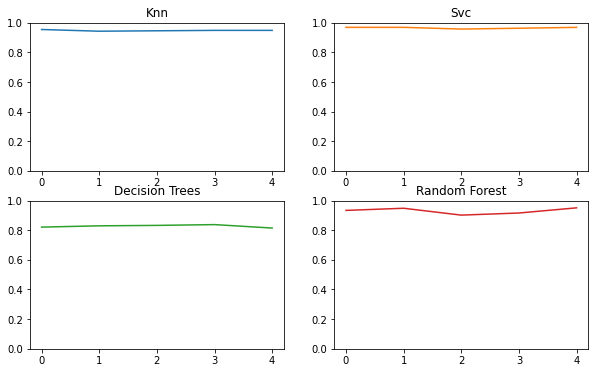

In [68]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

fix, axs = plt.subplots(2,2)

knn_ax = [0.95376, 0.94220, 0.94509, 0.94783, 0.94783]
svc_ax = [0.96821, 0.96821, 0.95665, 0.96232, 0.96812]
dt_ax = [0.82081, 0.82948, 0.83237, 0.83768, 0.81449]
rf_ax = [0.93353, 0.94798, 0.90173, 0.91594, 0.95072]

x = np.arange(5)

axs[0, 0].plot(x, knn_ax)
axs[0, 0].set_title('Knn')
axs[0, 0].set_ylim([0,1])
axs[0, 1].plot(x, svc_ax, 'tab:orange')
axs[0, 1].set_title('Svc')
axs[0, 1].set_ylim([0,1])
axs[1, 0].plot(x, dt_ax, 'tab:green')
axs[1, 0].set_title('Decision Trees')
axs[1, 0].set_ylim([0,1])
axs[1, 1].plot(x, rf_ax, 'tab:red')
axs[1, 1].set_title('Random Forest')
axs[1, 1].set_ylim([0,1])

plt.show()


Uit de grafieken kunnen we concluderen dat alle algoritmes consistent presteren. Ons interesse gaat voornamelijk naar de SVC classifier, vanwege de hoge resultaten.

## Resultaten

In de vorige hoofdstuk hebben we geconcludeerd dat de SVC classifier de beste keuze is voor  nummer herkenning. Daarnaast lijkt een combinatie van features tot betere resultaten te leiden. Nu is het tijd om de algoritme te gebruiken voor het classificeren van postcodes.

Hiervoor gaan we de totale dataset aan 480 afbeeldingen gebruiken en deze splitsen in train en test data. De test data zullen we  uiteindelijk gebruiken voor het berekenen van de accuraatheid.

In [69]:
all_zipcodes = []
total_images = len(test_images_df.index)

#standardScaler = StandardScaler()
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
        result[features], result['zip_number'], test_size=0.2, random_state=0)

X_train[features] = scaler.fit_transform(X_train[features].to_numpy())
X_test[features] = scaler.transform(X_test[features].to_numpy())
#train model
svc_clf = SVC(C=10, gamma=1)
svc_clf.fit(X_train, y_train)

score = svc_clf.score(X_test, y_test)
print('---------score from test------------------- ')
print(score)



---------score from test------------------- 
0.9595375722543352


In [70]:
for i in range(0, total_images):
    
    image_name = test_images_df.iloc[i, 0]
    image = test_images_df.iloc[i, 1]
    tmp_result_grid = initialize_image_grids(image, image_name)
    tmp_result_props = initialize_image_props(image, image_name)
    test_result = pd.concat([tmp_result_grid,tmp_result_props], axis=1)
    test_result.reset_index(inplace=True,drop=True)
    test_result['zip_number'] = test_result['zip_number'].astype(int)
    test_result[features] = scaler.transform(test_result[features].to_numpy())
    
    # classify
    predicted = svc_clf.predict(test_result[features])
    #print(predicted)
    all_zipcodes.append(predicted)


In [71]:
def concat(a, b, c, d):
    return int(f"{a}{b}{c}{d}")

In [72]:
positive = 0
for i in range(0, len(all_zipcodes)):
    print('predicted: ', all_zipcodes[i][0], all_zipcodes[i][1], all_zipcodes[i][2], all_zipcodes[i][3])
    print('original: ',  test_images_df.loc[i,['name']].to_numpy())
    concatted = concat(all_zipcodes[i][0], all_zipcodes[i][1], all_zipcodes[i][2], all_zipcodes[i][3])
    if concatted == int(test_images_df.loc[i,['name']]):
        positive = positive + 1
    
numberItems = len(all_zipcodes)

accuracyy = positive / numberItems * 100

print('accuracy is: ', accuracyy)

predicted:  1 4 8 9
original:  ['1489']
predicted:  1 8 6 5
original:  ['1865']
predicted:  1 9 0 4
original:  ['1904']
predicted:  2 6 0 8
original:  ['2608']
predicted:  2 7 0 8
original:  ['2708']
predicted:  2 9 7 1
original:  ['2971']
predicted:  3 3 4 6
original:  ['3046']
predicted:  3 4 1 7
original:  ['3417']
predicted:  5 5 2 1
original:  ['3521']
predicted:  3 5 3 6
original:  ['3536']
predicted:  3 5 9 1
original:  ['3591']
predicted:  3 6 0 6
original:  ['3606']
predicted:  3 6 4 1
original:  ['3648']
predicted:  3 7 1 1
original:  ['3711']
predicted:  3 7 4 6
original:  ['3746']
predicted:  3 9 2 1
original:  ['3921']
predicted:  3 9 8 9
original:  ['3988']
predicted:  4 0 0 6
original:  ['4006']
predicted:  4 1 3 4
original:  ['4134']
predicted:  4 7 6 9
original:  ['4764']
predicted:  5 0 7 1
original:  ['5071']
predicted:  5 5 3 9
original:  ['5539']
predicted:  5 5 5 1
original:  ['5551']
predicted:  5 5 7 8
original:  ['5578']
predicted:  5 6 4 3
original:  ['5643']


## Conclusie

De algoritme levert een accuraatheid op van 83.3%. Dit is een hoger resultaat dan de vorige notebook. Voor de zekerheid heb ik ook gebruikt gemaakt van de standardscalar. Dit levert een nog lagere score op. Het lijkt erop dat een combinatie van image based en grid based classificatie leidt tot betere resultaten.

In [73]:
import joblib

joblib.dump(scaler, '../classifiers/best_preprocessor.pkl')
joblib.dump(svc_clf, '../classifiers/best_classifier.pkl')

['../classifiers/best_classifier.pkl']